# Pylops - basic linear operators on GPU with cupy

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops* and test both their numpy and cupy backends.

In [1]:
!nvidia-smi

Sun Feb 14 11:32:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:65:00.0  On |                  N/A |
| 30%   45C    P0    37W / 125W |   2068MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  1
Core(s) per socket:  8
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) W-2145 CPU @ 3.70GHz
Stepping:            4
CPU MHz:             4302.853
CPU max MHz:         4500.0000
CPU min MHz:         1200.0000
BogoMIPS:            7399.70
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            11264K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 s

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import timeit
import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.optimization.solver import cgls
from pylops.optimization.leastsquares import *

plt.style.use('seaborn-dark')

In [5]:
cp.__version__

'8.4.0'

In [6]:
def timing(cmd_setup, df, method, number=10, repeat=5):
    print('Timing %s' % method)

    # _matvec
    mat_np = 'Op._matvec(x)'
    mat_cp = 'cOp._matvec(xc)'

    # _matvec
    rmat_np = 'Op._rmatvec(y)'
    rmat_cp = 'cOp._rmatvec(yc)'

    # dry run
    timeit.repeat(mat_cp, setup=cmd_setup, number=1, repeat=1)
    timeit.repeat(rmat_cp, setup=cmd_setup, number=1, repeat=1)

    # timing
    tm_ = 1.e3 * np.array(timeit.repeat(mat_np, setup=cmd_setup,
                                      number=number, repeat=repeat))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_np, setup=cmd_setup,
                                       number=number, repeat=repeat))
    for i in range(repeat):
        df.loc[len(df)] = [method, True, 'np', tm_[i]]
    for i in range(repeat):
        df.loc[len(df)] = [method, False, 'np', + trm_[i]]

    tm_ = 1.e3 * np.array(timeit.repeat(mat_cp, setup=cmd_setup,
                                      number=number, repeat=repeat))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_cp, setup=cmd_setup,
                                       number=number, repeat=repeat))
    for i in range(repeat):
        df.loc[len(df)] = [method, True, 'cp', tm_[i]]
    for i in range(repeat):
        df.loc[len(df)] = [method, False, 'cp', trm_[i]]
    return df

# Elementary operators

In [7]:
df = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

## Diagonal

In [8]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
d = np.arange(n) + 1.
y = x = np.ones(n, dtype=np.float32)
yc = xc = cp.ones(n, dtype=np.float32)
Op = pylops.Diagonal(d)
cOp = pylops.Diagonal(cp.array(d))
"""

df = timing(cmd_setup, df, 'Diagonal')

Timing Diagonal


## Matrix Multiplication

In [9]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 1000
D = np.ones((n, n), dtype=np.float32)
y = x = np.ones(n, dtype=np.float32)
yc = xc = cp.ones(n, dtype=np.float32)
Op = pylops.MatrixMult(D)
cOp = pylops.MatrixMult(cp.array(D))
"""

df = timing(cmd_setup, df, 'MatrixMult')

Timing MatrixMult


## Identity

In [10]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n//2, dtype=np.float32)
xc = cp.ones(n//2, dtype=np.float32)
y = np.ones(n, dtype=np.float32)
yc = cp.ones(n, dtype=np.float32)
Op = pylops.Identity(n, n//2)
cOp = pylops.Identity(n, n//2)
"""

df = timing(cmd_setup, df, 'Identity')

Timing Identity


## Zero

In [11]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = int(1e6), int(1e6)
y = x = cp.arange(nx, dtype=np.float32)
yc = xc = cp.ones(nx, dtype=np.float32)
Op = pylops.Zero(ny, nx)
cOp = pylops.Zero(ny, nx)
"""

df = timing(cmd_setup, df, 'Zero')

Timing Zero


## Sum

In [12]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx, dtype=np.float32)
yc = cp.ones(nx, dtype=np.float32)
Op = pylops.Sum(dims=(ny, nx), dir=0)
cOp = pylops.Sum(dims=(ny, nx), dir=0)
"""
df = timing(cmd_setup, df, 'Sum')

Timing Sum


## First Derivative

In [13]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.FirstDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
cOp = pylops.FirstDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
"""
df = timing(cmd_setup, df, 'FirstDerivative')

Timing FirstDerivative


## Second Derivative

In [14]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.SecondDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
cOp = pylops.SecondDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
"""
df = timing(cmd_setup, df, 'SecondDerivative')

Timing SecondDerivative


## Laplacian

In [15]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.Laplacian((ny, nx), edge=True)
cOp = pylops.Laplacian((ny, nx), edge=True)
"""
df = timing(cmd_setup, df, 'Laplacian')

Timing Laplacian


## Gradient

In [16]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.Laplacian((ny, nx), edge=True)
cOp = pylops.Laplacian((ny, nx), edge=True)
"""
df = timing(cmd_setup, df, 'Gradient')

Timing Gradient


## Causal Integration

In [17]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.CausalIntegration(ny*nx, (ny, nx), dir=1)
cOp = pylops.CausalIntegration(ny*nx, (ny, nx), dir=1)
"""
df = timing(cmd_setup, df, 'CausalIntegration')

Timing CausalIntegration


## Flip

In [18]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.Flip(ny*nx, (ny, nx), dir=1)
cOp = pylops.Flip(ny*nx, (ny, nx), dir=1)
"""
df = timing(cmd_setup, df, 'Flip')

Timing Flip


## Pad

In [19]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
pad = (200, 200)
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n + 400, dtype=np.float32)
yc = cp.ones(n + 400, dtype=np.float32)
Op = pylops.Pad(n, pad)
cOp = pylops.Pad(n, pad)
"""
df = timing(cmd_setup, df, 'Pad')

Timing Pad


## Roll

In [20]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n, dtype=np.float32)
yc = cp.ones(n, dtype=np.float32)
Op = pylops.Roll(n, shift=20)
cOp = pylops.Roll(n, shift=20)
"""
df = timing(cmd_setup, df, 'Roll')

Timing Roll


## Symmetrize


In [21]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n*2-1, dtype=np.float32)
yc = cp.ones(n*2-1, dtype=np.float32)
Op = pylops.Symmetrize(n)
cOp = pylops.Symmetrize(n)
"""
df = timing(cmd_setup, df, 'Symmetrize')

Timing Symmetrize


## Restriction

In [22]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
iava = np.arange(0,n,10)
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n//10, dtype=np.float32)
yc = cp.ones(n//10, dtype=np.float32)
Op = pylops.Restriction(n, iava)
cOp = pylops.Restriction(n, iava)
"""
df = timing(cmd_setup, df, 'Restriction')

Timing Restriction


## Transpose

In [23]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.Transpose((ny, nx), axes=(1,0))
cOp = pylops.Transpose((ny, nx), axes=(1,0))
"""
df = timing(cmd_setup, df, 'Transpose')

Timing Transpose


## FFT

In [24]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n*2-1, dtype=np.float32)
yc = cp.ones(n*2-1, dtype=np.float32)
Op = pylops.signalprocessing.FFT(dims=[n], nfft=n)
cOp = pylops.signalprocessing.FFT(dims=[n], nfft=n)
"""
df = timing(cmd_setup, df, 'FFT')

Timing FFT


## FFT2D

In [25]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype=np.float32)
xc = cp.ones(nx*ny, dtype=np.float32)
y = np.ones(nx*ny, dtype=np.float32)
yc = cp.ones(nx*ny, dtype=np.float32)
Op = pylops.signalprocessing.FFT2D(dims=[ny, nx])
cOp = pylops.signalprocessing.FFT2D(dims=[ny, nx])
"""
df = timing(cmd_setup, df, 'FFT2D')

Timing FFT2D


## FFTND

In [26]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nz, ny, nx = 50, 100, 100
x = np.ones(nz*nx*ny, dtype=np.float32)
xc = cp.ones(nz*nx*ny, dtype=np.float32)
y = np.ones(nz*nx*ny, dtype=np.float32)
yc = cp.ones(nz*nx*ny, dtype=np.float32)
Op = pylops.signalprocessing.FFTND(dims=[nz, ny, nx])
cOp = pylops.signalprocessing.FFTND(dims=[nz, ny, nx])
"""
df = timing(cmd_setup, df, 'FFTND')

Timing FFTND


## Convolve 1D

In [27]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n, dtype=np.float32)
yc = cp.ones(n, dtype=np.float32)
h = np.ones(25, dtype=np.float32)
hc = cp.ones(25, dtype=np.float32)
Op = pylops.signalprocessing.Convolve1D(n, h)
cOp = pylops.signalprocessing.Convolve1D(n, hc)
"""
df = timing(cmd_setup, df, 'Convolve1D')

Timing Convolve1D


## Convolve2D

In [28]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nx = 1000, 1000
h = np.ones((5,5), dtype=np.float32)
hc = cp.ones((5,5), dtype=np.float32)
x = np.ones(nt*nx, dtype=np.float32)
xc = cp.ones(nt*nx, dtype=np.float32)
y = np.ones(nt*nx, dtype=np.float32)
yc = cp.ones(nt*nx, dtype=np.float32)
Op = pylops.signalprocessing.Convolve2D(nt*nx, h, (nt, nx))
cOp = pylops.signalprocessing.Convolve2D(nt*nx, h, (nt, nx))

"""
df = timing(cmd_setup, df, 'Convolve2D')

Timing Convolve2D


## ConvolveND

In [29]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, ny, nx = 100, 100, 100
h = np.ones((10, 10, 10), dtype=np.float32)
hc = cp.ones((10,10), dtype=np.float32)
x = np.ones(nt*ny*nx, dtype=np.float32)
xc = cp.ones(nt*ny*nx, dtype=np.float32)
y = np.ones(nt*ny*nx, dtype=np.float32)
yc = cp.ones(nt*ny*nx, dtype=np.float32)
Op = pylops.signalprocessing.ConvolveND(nt*ny*nx, h, (nt, ny, nx))
cOp = pylops.signalprocessing.ConvolveND(nt*ny*nx, h, (nt, ny, nx))

"""
df = timing(cmd_setup, df, 'ConvolveND')

Timing ConvolveND


## ChirpRadon2D

In [30]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh = 1000, 1000
t = np.arange(nt, dtype=np.float32)
h = np.arange(nh, dtype=np.float32)
x = np.ones(nt*nh, dtype=np.float32)
xc = cp.ones(nt*nh, dtype=np.float32)
y = np.ones(nt*nh, dtype=np.float32)
yc = cp.ones(nt*nh, dtype=np.float32)
Op = pylops.signalprocessing.ChirpRadon2D(t, h, 0.001)
cOp = pylops.signalprocessing.ChirpRadon2D(t, h, 0.001)

"""
df = timing(cmd_setup, df, 'ChirpRadon2D')

Timing ChirpRadon2D


## ChirpRadon3D

In [31]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh1, nh2 = 100, 100, 100
t = np.arange(nt)
h1 = np.arange(nh1, dtype=np.float32)
h2 = np.arange(nh2, dtype=np.float32)
x = np.ones(nt*nh1*nh2, dtype=np.float32)
xc = cp.ones(nt*nh1*nh2, dtype=np.float32)
y = np.ones(nt*nh1*nh2, dtype=np.float32)
yc = cp.ones(nt*nh1*nh2, dtype=np.float32)
Op = pylops.signalprocessing.ChirpRadon3D(t, h1, h2, (0.001, 0.001), engine='fftw')
cOp = pylops.signalprocessing.ChirpRadon3D(t, h1, h2, (0.001, 0.001))

"""
df = timing(cmd_setup, df, 'ChirpRadon3D')

Timing ChirpRadon3D


## Interp

In [32]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
iava = np.arange(0,n,10) + 0.5
x = np.ones(n, dtype=np.float32)
xc = cp.ones(n, dtype=np.float32)
y = np.ones(n//10, dtype=np.float32)
yc = cp.ones(n//10, dtype=np.float32)
Op = pylops.signalprocessing.Interp(n, iava, kind='nearest')[0]
cOp = pylops.signalprocessing.Interp(n, iava, kind='nearest')[0]
"""
df = timing(cmd_setup, df, 'Interp')

Timing Interp


## Bilinear

In [33]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nx = 1000, 1000
#iava = np.vstack((np.arange(0,nt,2),
#                  np.arange(0,nx,2)))
iava = np.vstack((np.hstack([i * np.ones(100) for i in range(nt-1)]),
                  np.hstack([np.random.permutation(np.arange(100)) for i in range(nt-1)])))
iavac = cp.asarray(iava)
x = np.ones(nt*nx, dtype=np.float32)
xc = cp.ones(nt*nx, dtype=np.float32)
y = np.ones(iava.shape[1], dtype=np.float32)
yc = cp.ones(iava.shape[1], dtype=np.float32)
Op = pylops.signalprocessing.Bilinear(iava, (nt, nx))
cOp = pylops.signalprocessing.Bilinear(iavac, (nt, nx))
"""
df = timing(cmd_setup, df, 'Bilinear')

Timing Bilinear


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal/lib/python3.8/site-packages/cupyx/_scatter.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[cupy.array(seq)]`, which will result either in an error or a different result.
  a.scatter_add(slices, value)
/home/ravasim/Documents/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/home/ravasim/Documents/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` ins

## Fredholm1

In [34]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh1, nh2, nz = 100, 50, 50, 20
h = np.ones((nt, nh1, nh2))
hc = cp.ones((nt, nh1, nh2))
x = np.ones(nt*nh2*nz, dtype=np.float32)
xc = cp.ones(nt*nh2*nz, dtype=np.float32)
y = np.ones(nt*nh1*nz, dtype=np.float32)
yc = cp.ones(nt*nh1*nz, dtype=np.float32)
Op = pylops.signalprocessing.Fredholm1(h, nz)
cOp = pylops.signalprocessing.Fredholm1(hc, nz)
"""
df = timing(cmd_setup, df, 'Fredholm1')

Timing Fredholm1


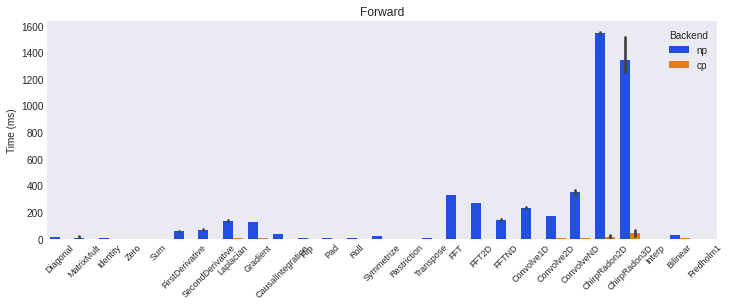

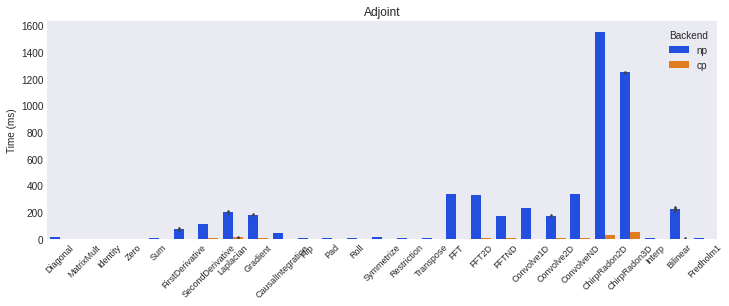

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==True], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==False], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9);

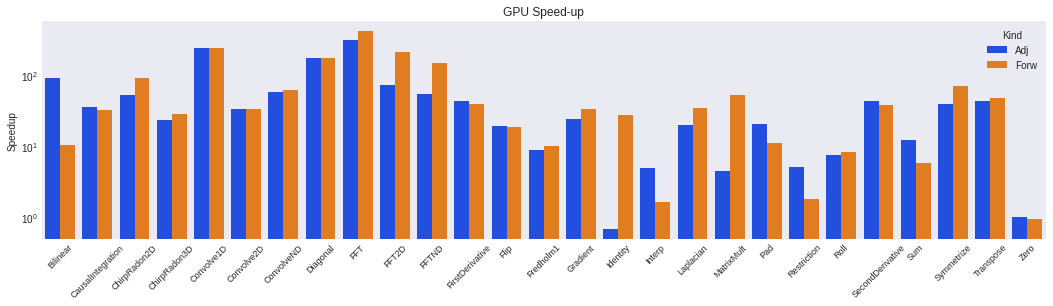

In [36]:
df_np = df[df['Backend'] == 'np']
df_cp = df[df['Backend'] == 'cp']

df_speedup = df_np.groupby(['Method', 'Forw']).mean() / df_cp.groupby(['Method', 'Forw']).mean()
df_speedup = pd.DataFrame(df_speedup.to_records())
df_speedup['Forw'] = df_speedup['Forw'].map({True: 'Forw', False: 'Adj'})
df_speedup = df_speedup.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

fig, ax = plt.subplots(figsize=(18, 4))
g = sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_speedup, palette="bright")
g.set_yscale("log")
ax.set_xlabel('')
ax.set_title('GPU Speed-up')
ax.set_xticklabels(df_speedup['Method'].unique(),rotation=45, fontsize=9);

plt.savefig('Speedup.eps', dpi=300, bbox_inches='tight')

In [37]:
print(df_speedup)

               Method  Kind     Speedup
0            Bilinear   Adj   92.635327
1            Bilinear  Forw   10.668455
2   CausalIntegration   Adj   36.144658
3   CausalIntegration  Forw   32.706233
4        ChirpRadon2D   Adj   54.199493
5        ChirpRadon2D  Forw   92.298839
6        ChirpRadon3D   Adj   23.462541
7        ChirpRadon3D  Forw   28.752521
8          Convolve1D   Adj  249.953098
9          Convolve1D  Forw  247.055225
10         Convolve2D   Adj   33.675707
11         Convolve2D  Forw   33.576858
12         ConvolveND   Adj   58.218418
13         ConvolveND  Forw   62.263072
14           Diagonal   Adj  178.211442
15           Diagonal  Forw  178.587411
16                FFT   Adj  321.278548
17                FFT  Forw  423.843180
18              FFT2D   Adj   74.052367
19              FFT2D  Forw  214.763032
20              FFTND   Adj   55.020680
21              FFTND  Forw  150.927905
22    FirstDerivative   Adj   43.509091
23    FirstDerivative  Forw   40.276087


In [38]:
print('Average speed-up operators', np.mean(df_speedup['Speedup']))

Average speed-up operators 62.28668943083315


# Composite operators

## PoststackLinearModelling

In [39]:
df_comp = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

number, repeat = 10, 5

In [40]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0]).astype(np.float32)
wavc = cp.asarray(wav)
nt, nx = 1000, 1000
x = np.ones(nt*nx, dtype=np.float32)
xc = cp.ones(nt*nx, dtype=np.float32)
y = np.ones(nt*nx, dtype=np.float32)
yc = cp.ones(nt*nx, dtype=np.float32)
Op = pylops.avo.poststack.PoststackLinearModelling(wav, nt, nx)
cOp = pylops.avo.poststack.PoststackLinearModelling(wavc, nt, nx)
"""
df_comp = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])
df_comp = timing(cmd_setup, df_comp, 'PoststackLinearModelling_2D', number=number, repeat=repeat)

Timing PoststackLinearModelling_2D


In [41]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0]).astype(np.float32)
wavc = cp.asarray(wav)
nt, nx, ny = 1000, 10, 100
x = np.ones(nt*nx*ny, dtype=np.float32)
xc = cp.ones(nt*nx*ny, dtype=np.float32)
y = np.ones(nt*nx*ny, dtype=np.float32)
yc = cp.ones(nt*nx*ny, dtype=np.float32)
Op = pylops.avo.poststack.PoststackLinearModelling(wav, nt, (nx, ny))
cOp = pylops.avo.poststack.PoststackLinearModelling(wavc, nt, (nx, ny))
"""
df_comp = timing(cmd_setup, df_comp, 'PoststackLinearModelling_3D', number=number, repeat=repeat)

Timing PoststackLinearModelling_3D


## PrestackLinearModelling

In [42]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0]).astype(np.float32)
wavc = cp.asarray(wav)
theta = np.arange(0, 30, 5.).astype(np.float32)
thetac = cp.arange(0, 30, 5.).astype(np.float32)
ntheta = len(theta)
nt, nx = 1000, 1000
x = np.ones(nt*nx*3, dtype=np.float32)
xc = cp.ones(nt*nx*3, dtype=np.float32)
y = np.ones(nt*nx*ntheta, dtype=np.float32)
yc = cp.ones(nt*nx*ntheta, dtype=np.float32)
Op = pylops.avo.prestack.PrestackLinearModelling(wav, theta, 0.5, nt, nx)
cOp = pylops.avo.prestack.PrestackLinearModelling(wavc, thetac, 0.5, nt, nx)
"""
df_comp = timing(cmd_setup, df_comp, 'PrestackLinearModelling_2D', number=number, repeat=repeat)

Timing PrestackLinearModelling_2D


In [43]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0]).astype(np.float32)
wavc = cp.asarray(wav)
theta = np.arange(0, 30, 5.).astype(np.float32)
thetac = cp.arange(0, 30, 5.).astype(np.float32)
ntheta = len(theta)
nt, nx, ny = 1000, 10, 100
x = np.ones(nt*nx*ny*3, dtype=np.float32)
xc = cp.ones(nt*nx*ny*3, dtype=np.float32)
y = np.ones(nt*nx*ny*ntheta, dtype=np.float32)
yc = cp.ones(nt*nx*ny*ntheta, dtype=np.float32)
Op = pylops.avo.prestack.PrestackLinearModelling(wav, theta, 0.5, nt, (nx, ny))
cOp = pylops.avo.prestack.PrestackLinearModelling(wavc, thetac, 0.5, nt, (nx, ny))
"""
df_comp = timing(cmd_setup, df_comp, 'PrestackLinearModelling_3D', number=number, repeat=repeat)

Timing PrestackLinearModelling_3D


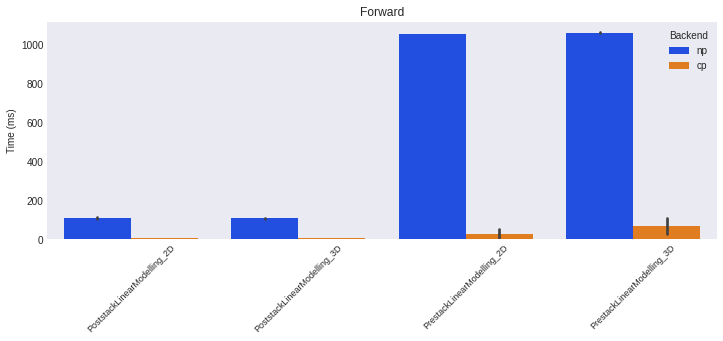

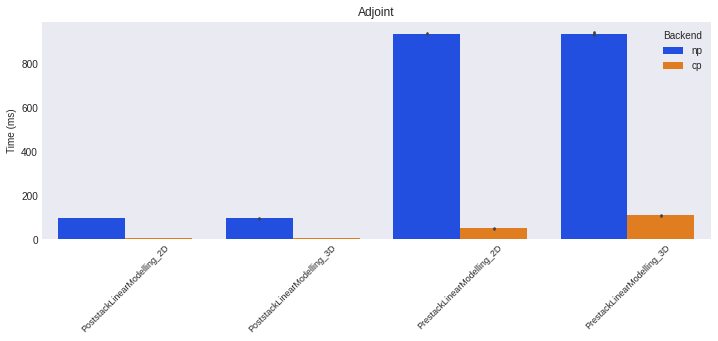

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==True], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==False], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9);

In [45]:
df_comp_np = df_comp[df_comp['Backend'] == 'np']
df_comp_cp = df_comp[df_comp['Backend'] == 'cp']

df_comp_speedup = df_comp_np.groupby(['Method', 'Forw']).mean() / df_comp_cp.groupby(['Method', 'Forw']).mean()
df_comp_speedup = pd.DataFrame(df_comp_speedup.to_records())
df_comp_speedup['Forw'] = df_comp_speedup['Forw'].map({True: 'Forw', False: 'Adj'})
df_comp_speedup = df_comp_speedup.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

In [46]:
print(df_comp_speedup)

                        Method  Kind    Speedup
0  PoststackLinearModelling_2D   Adj  15.570249
1  PoststackLinearModelling_2D  Forw  18.211856
2  PoststackLinearModelling_3D   Adj  13.423212
3  PoststackLinearModelling_3D  Forw  15.791227
4   PrestackLinearModelling_2D   Adj  18.774801
5   PrestackLinearModelling_2D  Forw  36.875700
6   PrestackLinearModelling_3D   Adj   8.555531
7   PrestackLinearModelling_3D  Forw  15.249609


In [47]:
print('Average speed-up Convmodelling', np.mean(df_comp_speedup['Speedup']))

Average speed-up Convmodelling 17.80652291387155


## PhaseShift

In [48]:
df_comp = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

number, repeat = 10, 5

In [49]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
vel = 1500.
zprop = 100
pad = 11
nt, dt = 1000, 0.004
nx, dx = 1000, 10
freq = np.fft.rfftfreq(nt, dt).astype(np.float32)
kx = np.fft.fftshift(np.fft.fftfreq(nx + 2*pad, dx)).astype(np.float32)
x = np.ones(nt*(nx+2*pad), dtype=np.float32)
xc = cp.ones(nt*(nx+2*pad), dtype=np.float32)
y = np.ones(nt*(nx+2*pad), dtype=np.float32)
yc = cp.ones(nt*(nx+2*pad), dtype=np.float32)
Op = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, freq, kx, dtype=np.float32)
cOp = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, cp.asarray(freq), cp.asarray(kx), dtype=np.float32)
"""
df_comp = timing(cmd_setup, df_comp, 'PhaseShift_2D', number=number, repeat=repeat)

Timing PhaseShift_2D


In [50]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
vel = 1500.
zprop = 100
pad = 11
nt, dt = 100, 0.004
nx, dx = 100, 10
ny, dy = 100, 10
freq = np.fft.rfftfreq(nt, dt).astype(np.float32)
kx = np.fft.fftshift(np.fft.fftfreq(nx + 2*pad, dx)).astype(np.float32)
ky = np.fft.fftshift(np.fft.fftfreq(ny + 2*pad, dy)).astype(np.float32)
x = np.ones(nt*(nx+2*pad)*(ny+2*pad), dtype=np.float32)
xc = cp.ones(nt*(nx+2*pad)*(ny+2*pad), dtype=np.float32)
y = np.ones(nt*(nx+2*pad)*(ny+2*pad), dtype=np.float32)
yc = cp.ones(nt*(nx+2*pad)*(ny+2*pad), dtype=np.float32)
Op = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, freq, kx, ky, dtype=np.float32)
cOp = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, cp.asarray(freq), cp.asarray(kx), cp.asarray(ky), dtype=np.float32)
"""
df_comp = timing(cmd_setup, df_comp, 'PhaseShift_3D', number=number, repeat=repeat)

Timing PhaseShift_3D


In [51]:
#df_comp['Time'] /= 1000 # ms -> s

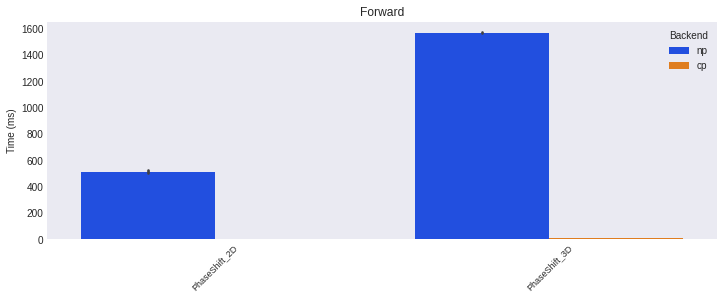

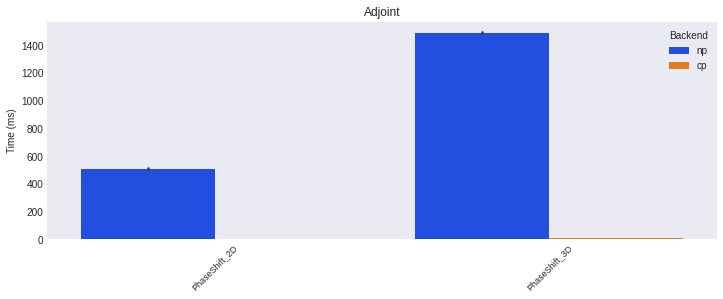

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==True], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==False], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9);

In [53]:
df_comp_np = df_comp[df_comp['Backend'] == 'np']
df_comp_cp = df_comp[df_comp['Backend'] == 'cp']

df_comp_speedup1 = df_comp_np.groupby(['Method', 'Forw']).mean() / df_comp_cp.groupby(['Method', 'Forw']).mean()
df_comp_speedup1 = pd.DataFrame(df_comp_speedup1.to_records())
df_comp_speedup1['Forw'] = df_comp_speedup1['Forw'].map({True: 'Forw', False: 'Adj'})
df_comp_speedup1 = df_comp_speedup1.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

In [54]:
print(df_comp_speedup1)

          Method  Kind     Speedup
0  PhaseShift_2D   Adj   98.432660
1  PhaseShift_2D  Forw   99.276339
2  PhaseShift_3D   Adj  181.271611
3  PhaseShift_3D  Forw  190.685956


In [55]:
print('Average speed-up Phase shift', np.mean(df_comp_speedup1['Speedup']))

Average speed-up Phase shift 142.41664140477317


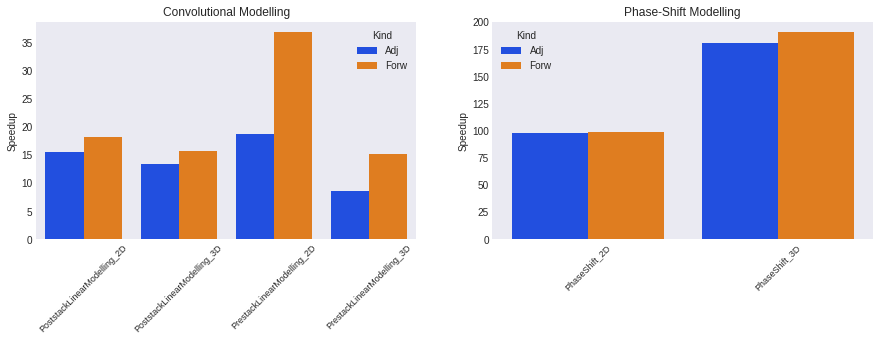

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_comp_speedup, palette="bright", ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_title('Convolutional Modelling')
axs[0].set_xticklabels(df_comp_speedup['Method'].unique(),rotation=45, fontsize=9);
sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_comp_speedup1, palette="bright", ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_title('Phase-Shift Modelling')
axs[1].set_xticklabels(df_comp_speedup1['Method'].unique(),rotation=45, fontsize=9);

plt.savefig('Speedup_composite.eps', dpi=300, bbox_inches='tight')